Run on NERSC

Bulk objects inspection; apply GAIA->LS filter transformation; compute averaged profiles

In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import sys, os, glob, time, warnings, gc

import healpy as hp

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    return ax

def binned_stats(x, y, bins):
    from scipy import stats
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    bin_center, bin_median, bin_scatter = np.zeros((3, len(bins)-1))
    for index in range(len(bins)-1):
        mask = (x>bins[index]) & (x<bins[index+1])
        bin_center[index] = np.median(x[mask])
        if np.sum(mask)>0:
            bin_median[index] = np.median(y[mask])
            bin_scatter[index] = nmad(y[mask])
        else:
            bin_median[index], bin_scatter[index] = np.nan, np.nan
    return bin_center, bin_median, bin_scatter

-------

In [4]:
ramin, ramax, decmin, decmax = 160, 210, -5, 20
field = 'south'
download_dir = '/global/cscratch1/sd/rongpu/temp/dr8_cutouts'

output_name = 'decals_ngc'

In [5]:
gaia_dir = '/project/projectdirs/cosmo/data/gaia/dr2/healpix'

gaia_nside = 32
gaia_npix = hp.nside2npix(gaia_nside)
gaia_hp_ra, gaia_hp_dec = hp.pix2ang(gaia_nside, np.arange(gaia_npix), nest=True, lonlat=True)
if ramin<ramax:
    gaia_list = np.where((gaia_hp_ra>ramin) & (gaia_hp_ra<ramax) & (gaia_hp_dec>decmin) & (gaia_hp_dec<decmax))[0]
else:
    gaia_list = np.where(((gaia_hp_ra>ramin) | (gaia_hp_ra<ramax)) & (gaia_hp_dec>decmin) & (gaia_hp_dec<decmax))[0]

gaia = []
for hp_idx in gaia_list:
    gaia_fn = (5-len(str(hp_idx)))*'0'+str(hp_idx)
    tmp = fitsio.read(os.path.join(gaia_dir, 'healpix-{}.fits'.format(gaia_fn)), colnames=['PHOT_G_MEAN_MAG'])
    # select GAIA_G<17.5 objects
    idx = np.where(tmp['PHOT_G_MEAN_MAG']<17.5)[0]
    tmp = fitsio.read(os.path.join(gaia_dir, 'healpix-{}.fits'.format(gaia_fn)), rows=idx)
    tmp = Table(tmp)
    gaia.append(tmp)
gaia = vstack(gaia)
print(len(gaia))

# convert column names to lower case
for col in gaia.colnames:
    gaia.rename_column(col, col.lower())
    
if ramin<ramax:
    mask = (gaia['ra']>ramin) & (gaia['ra']<ramax) & (gaia['dec']>decmin) & (gaia['dec']<decmax)
else:
    mask = ((gaia['ra']>ramin) | (gaia['ra']<ramax)) & (gaia['dec']>decmin) & (gaia['dec']<decmax)
gaia = gaia[mask]
print(len(gaia))

if field=='north':
    mask = gaia['dec']>32.375
else:
    mask = gaia['dec']<=32.375    
gaia = gaia[mask]
print(len(gaia))
    
# Remove the globular clusters and bad regions
mask = (gaia['ra']>198.0) & (gaia['ra']<198.5) & (gaia['dec']>18.0) & (gaia['dec']<18.4)
mask |=  (gaia['ra']>199.0) & (gaia['ra']<199.2) & (gaia['dec']>17.6) & (gaia['dec']<17.8)
mask |=  (gaia['ra']>182.4) & (gaia['ra']<182.65) & (gaia['dec']>18.44) & (gaia['dec']<18.64)
mask |= (gaia['ra']>13.0) & (gaia['ra']<13.4) & (gaia['dec']>-26.7) & (gaia['dec']<-26.45)
# mask |= (gaia['ra']>14.5) & (gaia['ra']<15.5) & (gaia['dec']>-34.0) & (gaia['dec']<-33.2)
gaia = gaia[~mask]
print(len(gaia))

gaia['bp_rp'] = gaia['phot_bp_mean_mag'] - gaia['phot_rp_mean_mag']
gaia['pm'] = np.sqrt(gaia['pmra']**2 + gaia['pmdec']**2)

# Remove duplicates
if len(np.unique(gaia['source_id']))<len(gaia):
    print('Duplicates exist!')
    gaia.sort('source_id')
    mask = gaia['source_id'][1:]==gaia['source_id'][:-1]
    mask = np.concatenate([[False], mask])
    gaia = gaia[~mask]
    
# Remove duplicated_source==True
mask = gaia['duplicated_source'].copy()
if np.sum(mask)>0:
    print('{} objects with duplicated_source==True'.format(np.sum(mask)))
    gaia = gaia[~mask]
    print(len(gaia))

# Remove objects with invalid GAIA color
mask = ~np.isfinite(gaia['bp_rp'])
mask |= (gaia['phot_bp_mean_mag']==0) | (gaia['phot_rp_mean_mag']==0)
if np.sum(mask)>0:
    print('{} objects with invalid bp_rp'.format(np.sum(mask)))
    gaia = gaia[~mask]
    print(len(gaia))

843921
807761
807761
805837
40690 objects with duplicated_source==True
765147
8190 objects with invalid bp_rp
756957


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in sqrt


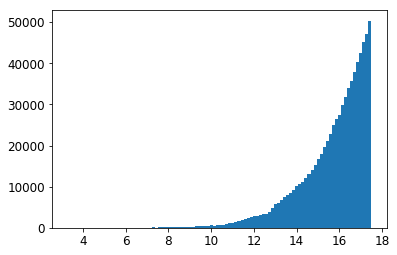

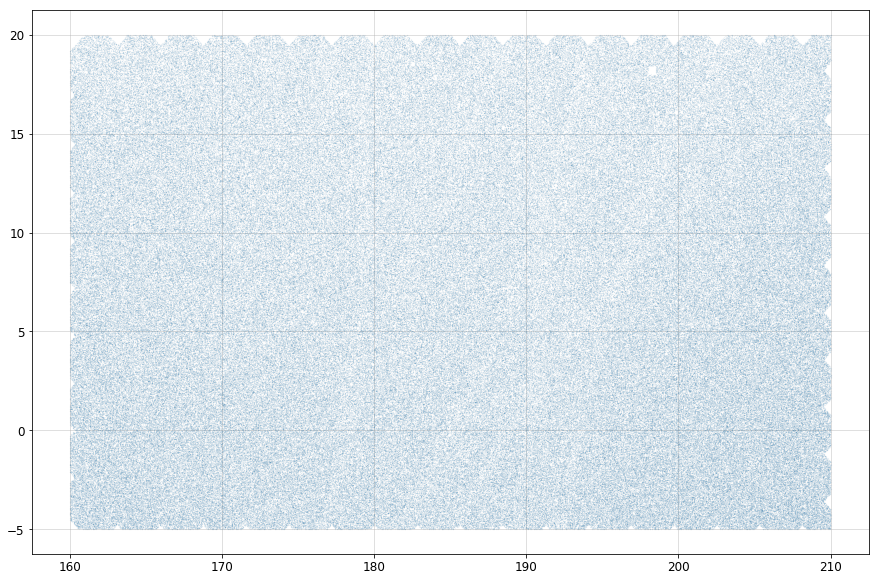

In [6]:
plt.hist(gaia['phot_g_mean_mag'], 100)
plt.show()

plt.figure(figsize=(15, 10))
plt.plot(gaia['ra'][::1], gaia['dec'][::1], '.', ms=0.1, alpha=0.5)
plt.grid(alpha=0.5)
# plt.axis([ramin, ramax, decmin, decmax])
plt.show()

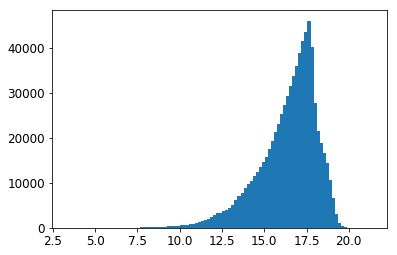

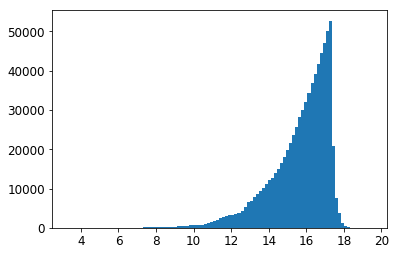

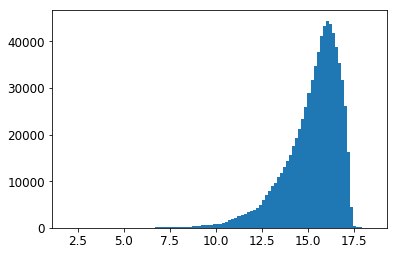

In [7]:
# Apply GAIA-LS transformation
from scipy.interpolate import interp1d
transform_interp = {}
for band in ['g', 'r', 'z']:
    if field=='north':
        tmp = np.load('data/gaia_bassmzls_{}_transform.npz'.format(band))
    else:
        tmp = np.load('data/gaia_decals_{}_transform.npz'.format(band))
    bin_center, bin_median, bin_scatter = tmp['arr_0'], tmp['arr_1'], tmp['arr_2']
    transform_interp[band] = interp1d(bin_center, bin_median, bounds_error=False, fill_value='extrapolate', kind='linear')
    gaia['ls_'+band] = gaia['phot_g_mean_mag'] + transform_interp[band](gaia['bp_rp'])

    plt.hist(gaia['ls_'+band], 100)
    plt.show()

-----

In [8]:
band = 'g'

# img_type = '-resid'
img_type = ''
if (field=='north') and ((band=='g') or (band=='r')):
    pixscale_str = '0.454'
else:
    pixscale_str = '0.262'
pixscale = float(pixscale_str)
size_str = '512'

# narrow bins of LS magnitude
ls_mag_bins = [10.5, 11.75, 13.0, 14.25, 15.5]
ls_mag_bin_width = 0.1
nsamp = 200

# plot the image and profiles of individual objects
individual_plot_q = False
plot_dir = '/global/homes/r/rongpu/notebooks/star_profiles/plots/11/'

verbose = False

for mag_index in range(len(ls_mag_bins)):
    ls_mag_min, ls_mag_max = ls_mag_bins[mag_index]-ls_mag_bin_width/2, ls_mag_bins[mag_index]+ls_mag_bin_width/2
    idx = np.where((gaia['ls_'+band]>ls_mag_min) & (gaia['ls_'+band]<ls_mag_max))[0]
    mask = gaia['pm'][idx]<50
    idx = idx[mask]
    print('{} objects in {} < {} < {}'.format(len(idx), ls_mag_min, band, ls_mag_max))

305 objects in 10.45 < g < 10.55
959 objects in 11.7 < g < 11.8
2225 objects in 12.95 < g < 13.05
5369 objects in 14.2 < g < 14.3
10264 objects in 15.45 < g < 15.55


0.00800441768819


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


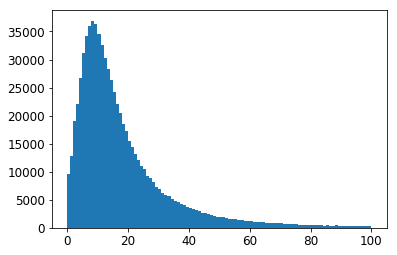

In [9]:
mask = gaia['pm']==0
print(np.sum(mask)/len(mask))
gaia['pm'] = np.sqrt(gaia['pmra']**2 + gaia['pmdec']**2)
plt.hist(gaia['pm'], 100, range=(0, 100))
plt.show()

In [10]:
radius_in_bin, flux_in_bin, flux_scatter_in_bin = [], [], []
gaia_output = []

for mag_index in range(len(ls_mag_bins)):

    ls_mag_min, ls_mag_max = ls_mag_bins[mag_index]-ls_mag_bin_width/2, ls_mag_bins[mag_index]+ls_mag_bin_width/2
    print('{} < {} < {}'.format(ls_mag_min, band, ls_mag_max))

    idx = np.where((gaia['ls_'+band]>ls_mag_min) & (gaia['ls_'+band]<ls_mag_max))[0]
    print(len(idx))
    
    # cut on proper motion
    mask = gaia['pm'][idx]<50
    idx = idx[mask]
    print(len(idx))
    
    if len(idx)>nsamp:
        np.random.seed(1)
        idx = np.sort(np.random.choice(idx, size=nsamp, replace=False))
    
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    radius_arr, flux_arr = [], []

    for index in idx:

        if verbose:
            print('phot_g_mean_mag = ', gaia['phot_g_mean_mag'][index])

        ra, dec = gaia['ra'][index], gaia['dec'][index]

        file_path = os.path.join(download_dir, field, '{}_{}{}_{}_{}.fits'.format(gaia['source_id'][index], band, img_type, pixscale_str, size_str))
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))

        if not os.path.isfile(file_path):
            url = 'http://legacysurvey.org/viewer/cutout.fits?ra={:f}&dec={:f}&layer=dr8-{}{}&pixscale={}&bands={}&size={}'.format(ra, dec, field, img_type, pixscale_str, band, size_str)
            cmd = 'wget -O '+file_path+' \"'+url+'\"'
            if verbose:
                print(cmd)
            os.system(cmd)

        img_raw = fitsio.read(file_path)
        img = img_raw / (pixscale**2)

        grid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
        xx, yy = np.meshgrid(grid, grid)
        radius = np.sqrt(xx**2 + yy**2).flatten()
        max_radius = xx.flatten().max() # maximum radius before hitting the edge of the image

        # Remove masked pixels
        mask = img.flatten()!=0
        radius = radius[mask]
        flux = img.flatten()[mask]

        bin_center, bin_median, bin_scatter = binned_stats(radius, flux, bins=np.linspace(0., np.floor(max_radius), int(np.floor(max_radius)+1)))
        # normalize to the magnitude bin center
        bin_median = bin_median * 10**((gaia['ls_'+band][index]-ls_mag_bins[mag_index])/2.5)
        radius_arr.append(bin_center)
        flux_arr.append(bin_median)
        
        if individual_plot_q:
            vrange = 0.5
            ax = plot_cutout(img, pixscale, vmin=-vrange, vmax=vrange)
            ax.set_title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
            plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_image.png'))
            plt.close()

            plt.figure(figsize=(8, 6))
            plt.plot(radius, flux, '.', ms=0.5)
            plt.plot(bin_center, bin_median, c='C1')
            plt.errorbar(bin_center, bin_median, yerr=bin_scatter, lw=1, alpha=0.6, c='C1')
            plt.axis([0, 70, -1, 5])
            plt.axhline(0, lw=1, color='r')
            plt.grid(alpha=0.5)
            plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
            plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_profile.png'))
            plt.close()

            plt.figure(figsize=(8, 6))
            plt.loglog(radius, flux, '.', ms=0.5)
            plt.plot(bin_center, bin_median, c='C1')
            plt.errorbar(bin_center, bin_median, yerr=bin_scatter, lw=1, alpha=0.6, c='C1')
            plt.axis([.5, 70, .02, 200])
            plt.grid(alpha=0.5)
            plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
            plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_profile_log.png'))
            plt.close()
    
    radius_arr = np.array(radius_arr)
    flux_arr = np.array(flux_arr)
    
    gaia_output_tmp = gaia[idx].copy()
    gaia_output_tmp['radius'] = radius_arr
    gaia_output_tmp['flux'] = flux_arr
    gaia_output_tmp['ls_'+band+'_bin'] = ls_mag_bins[mag_index]
    gaia_output.append(gaia_output_tmp)
    
    x, y, y_scatter = binned_stats(radius_arr.flatten(), flux_arr.flatten(), bins=np.linspace(0., np.floor(max_radius), int(np.floor(max_radius)+1)))
    radius_in_bin.append(x)
    flux_in_bin.append(y)
    flux_scatter_in_bin.append(y_scatter)
    
gaia_output = vstack(gaia_output)

10.45 < g < 10.55
381
305
11.7 < g < 11.8
1176
959
12.95 < g < 13.05
2459
2225
14.2 < g < 14.3
5778
5369
15.45 < g < 15.55
10760
10264


In [11]:
gaia_output[:3]

source_id,ref_cat,ra,dec,phot_g_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_mag,phot_bp_mean_flux_over_error,phot_rp_mean_mag,phot_rp_mean_flux_over_error,phot_bp_rp_excess_factor,astrometric_excess_noise,duplicated_source,astrometric_sigma5d_max,astrometric_params_solved,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,bp_rp,pm,ls_g,ls_r,ls_z,radius [66],flux [66],ls_g_bin
int64,bytes2,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,int8,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
1231164749199805952,G2,209.494112438,15.5157832176,10.2494,2502.15,10.5534,1570.69,9.81968,879.215,1.187,0.0,False,0.0414614,31,4.58607,0.0385419,-25.7651,0.0613692,-1.92715,0.0578891,0.733704,25.8371,10.5327139051,10.1849104349,10.0966682271,0.763854698225 .. 65.5023579576,150.135243497 .. 0.00285011297145,10.5
3597806868780099072,G2,181.487159137,-3.76608445039,10.365,2876.7,10.5331,840.745,10.0978,1059.21,1.17285,0.0,False,0.0670659,31,2.34405,0.0482633,-23.3958,0.105064,2.9706,0.058272,0.435278,23.5836,10.4589600211,10.3672217755,10.4455796254,0.763854698225 .. 65.5023579576,140.275441718 .. 0.00220733715001,10.5
3597856346803711360,G2,183.109194169,-4.25813321823,9.84153,5511.87,10.3918,1110.19,9.17842,1162.08,1.22631,0.0,False,0.0746975,31,1.29701,0.0565628,-23.6907,0.11458,1.90532,0.0751587,1.21337,23.7671,10.4927335525,9.69803954481,9.33655174375,0.763854698225 .. 65.5023579576,144.707354056 .. 0.00289848112117,10.5


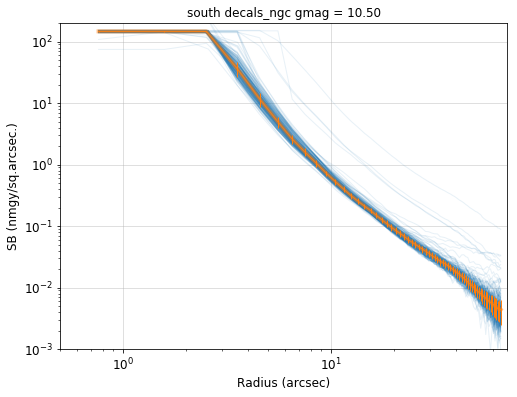

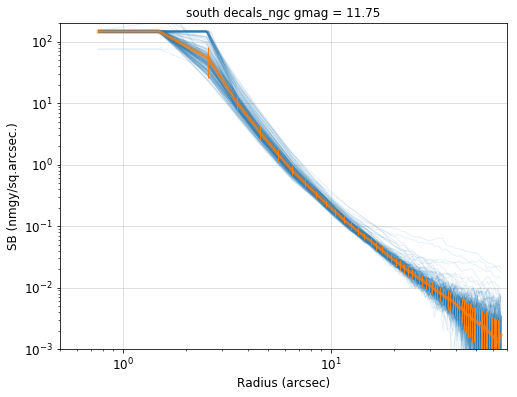

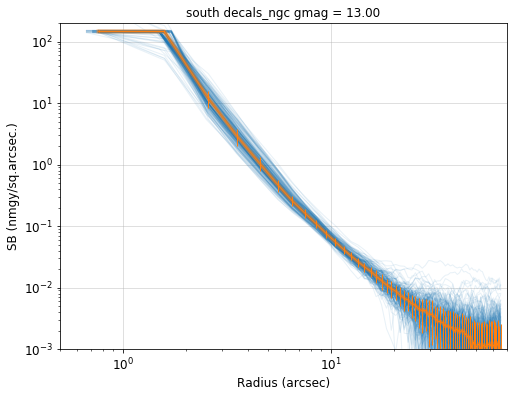

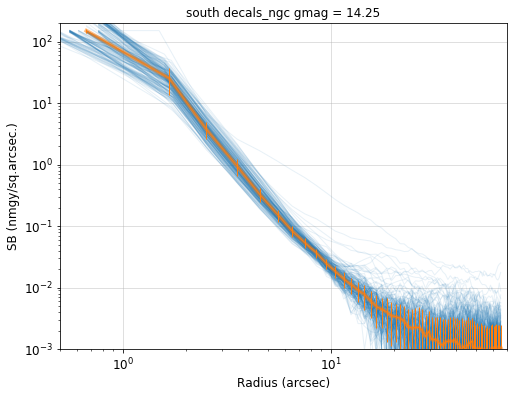

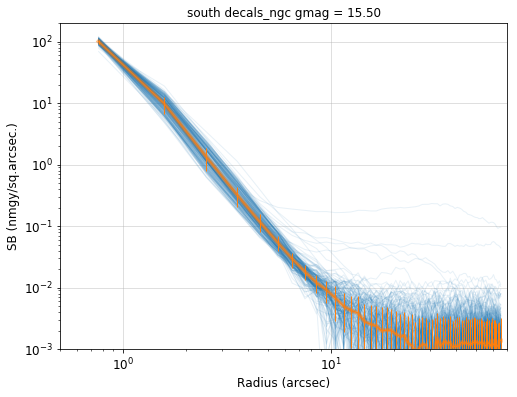

In [12]:
for index in range(len(ls_mag_bins)):
    mask = gaia_output['ls_'+band+'_bin']==ls_mag_bins[index]
    plt.figure(figsize=(8, 6))
    plt.loglog(gaia_output['radius'][mask].T, gaia_output['flux'][mask].T, lw=1, alpha=0.1, c='C0')
    plt.loglog(radius_in_bin[index], flux_in_bin[index], lw=4, alpha=0.5, c='C1')
    plt.errorbar(radius_in_bin[index], flux_in_bin[index], yerr=flux_scatter_in_bin[index],
                 lw=1, alpha=1, c='C1', zorder=5)
    plt.axis([.5, 70, .001, 200])
    plt.xlabel('Radius (arcsec)')
    plt.ylabel('SB (nmgy/sq.arcsec.)')
    plt.grid(alpha=0.5)
    plt.title('{} {} {}mag = {:.2f}'.format(field, output_name, band, ls_mag_bins[index]))
    plt.show()
    print()

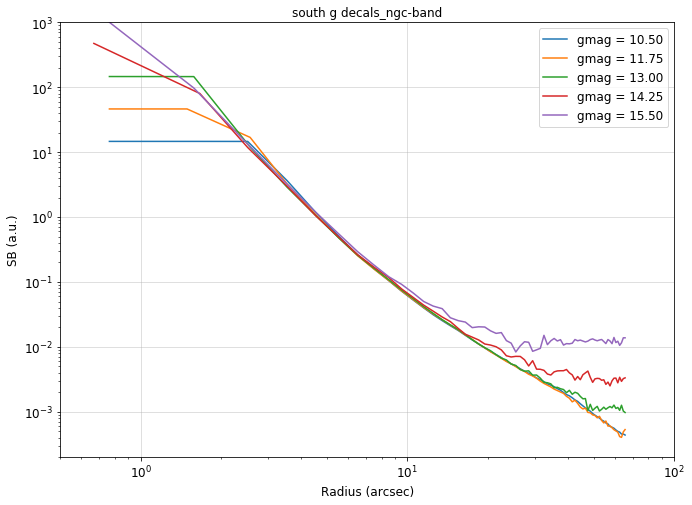

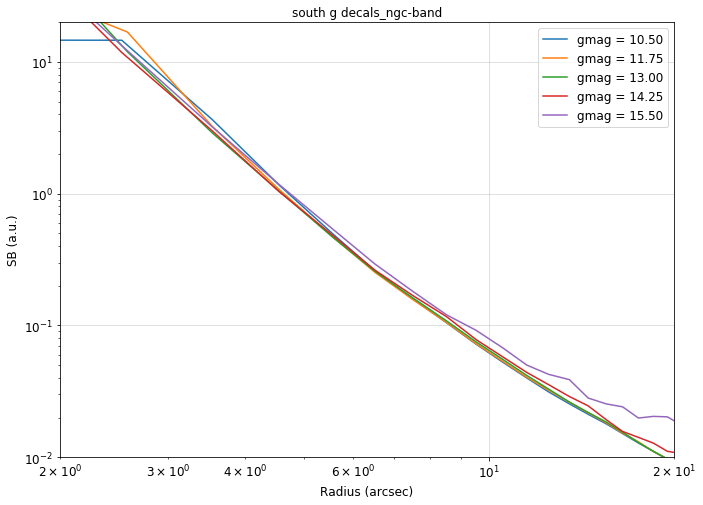

In [13]:
plt.figure(figsize=(11, 8))
for index in range(len(flux_in_bin)):
    # normalize the flux to 13th magnitude stars
    norm = 10**((ls_mag_bins[index]-13)/2.5)
    plt.loglog(radius_in_bin[index], flux_in_bin[index]*norm, lw=1.5, alpha=1., 
               label='{}mag = {:.2f}'.format(band, ls_mag_bins[index]), c='C'+str(index))
    # plt.errorbar(radius_in_bin[index], flux_in_bin[index]*norm, yerr=flux_scatter_in_bin[index],
    #              lw=1, alpha=1, c='C'+str(index), zorder=5)
plt.title('{} {} {}-band'.format(field, band, output_name))
plt.axis([.5, 100, .0002, 1000])
plt.grid(alpha=0.5)
plt.xlabel('Radius (arcsec)')
plt.ylabel('SB (a.u.)')
plt.legend()
plt.show()

plt.figure(figsize=(11, 8))
for index in range(len(flux_in_bin)):
    # normalize the flux to 13th magnitude stars
    norm = 10**((ls_mag_bins[index]-13)/2.5)
    plt.loglog(radius_in_bin[index], flux_in_bin[index]*norm, lw=1.5, alpha=1., 
               label='{}mag = {:.2f}'.format(band, ls_mag_bins[index]), c='C'+str(index))
plt.title('{} {} {}-band'.format(field, band, output_name))
plt.axis([2, 20, 0.01, 20])
plt.grid(alpha=0.5)
plt.xlabel('Radius (arcsec)')
plt.ylabel('SB (a.u.)')
plt.legend()
plt.show()

In [14]:
# gaia_output.write('data/individual_profiles_{}_{}_{}.fits'.format(field, output_name, band))

# t = Table()
# t['radius'] = radius_in_bin[0]
# for index in range(len(flux_in_bin)):
#     t['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])] = flux_in_bin[index]
# mask = t['radius']>=95.5
# t = t[~mask]
# t.write('data/average_profiles_{}_{}_{}.txt'.format(field, output_name, band), format='ascii.commented_header')